In [ ]:
# This notebook contains code to generate some extra diagrams, and to run EPSO properly.

In [4]:
# This code is Performs EPSO on a Discrete Graph
import pickle
import numpy as np
import random

# Loading the database
X = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['x']
print("shape of X:", np.shape(X))

y = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['y']
print("shape of y:", np.shape(y))

# A function to return the index of the input in the database
def input_index(Xinput):
  for i, input in enumerate(X):
    if np.array_equal(Xinput, input):
      return y[i]
  return None

shape of X: (98694, 7)
shape of y: (98694,)


In [5]:
# Evolutionary PSO code:

def objective_function(x):
    x = np.array(x)

    # Finding the closest data point in the dataset
    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    return y[closest_index]

# snap_position essentially snaps the input to the point in the database closest to it
def snap_position(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    snapped_input = X[closest_index]
    return snapped_input

# returns the index in the database closest to the input given to the method
def closest_index(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

# See Evolutionary_Graph_PSO for the working of EPSO
class Particle:
    def __init__(self, num_dimensions, init_position, index):
        self.position = init_position
        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = objective_function(self.position)
        self.index = index
        # This array is keeps track of all of the inputs in the database that the particle has visited. useful for generating plots later
        self.positions_traversed = [closest_index(init_position)]

class PSO:
    def __init__(self, num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, init_positions):
        self.num_particles = num_particles
        self.num_dimensions = num_dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.num_iterations = num_iterations
        self.particles = [Particle(num_dimensions, init_positions[ind], ind) for ind in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].position)
        self.global_best_fitness = self.particles[0].best_fitness
        # These arrays are used to generate some useful information used to plot graphs later
        self.unique_function_call_ids = []
        self.global_max_for_each_unique_function_call = []

    def update_particles(self):
        for particle in self.particles:
            particle.velocity = (self.w * particle.velocity
                                 + self.c1 * np.random.rand() * (particle.best_position - particle.position)
                                 + self.c2 * np.random.rand() * (self.global_best_position - particle.position))

            if(np.linalg.norm(particle.velocity) > 1.0):
                particle.velocity = particle.velocity / np.linalg.norm(particle.velocity)

            particle.position = particle.position + particle.velocity

            particle.position = np.clip(particle.position, self.lower_bound, self.upper_bound)
            particle.position = snap_position(particle.position)

            particle.positions_traversed.append(closest_index(particle.position))


    def update_personal_and_global_bests(self):
        for particle in self.particles:
            unique_function_called = False
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
                unique_function_called = True

            current_fitness = objective_function(particle.position)

            if current_fitness > particle.best_fitness:
                particle.best_position = np.copy(particle.position)
                particle.best_fitness = current_fitness

                if current_fitness > self.global_best_fitness:
                    self.global_best_position = np.copy(particle.position)
                    self.global_best_fitness = current_fitness

            if (unique_function_called == True):
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

    def eliminate(self):
        num_to_eliminate = int((self.num_particles / (self.num_iterations - 1)))
        if not self.particles:
            return []

        for _ in range(num_to_eliminate):
            min_index = 0
            for j in range(1, len(self.particles)):
                if (input_index(snap_position(self.particles[j].position)) < input_index(snap_position(self.particles[min_index].position))):
                    min_index = j
            self.particles.pop(min_index)

    def optimize(self):
        all_positions_traversed = []
        for i in range(self.num_particles):
            all_positions_traversed.append([0.0])

        for particle in self.particles:
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
            if particle.best_fitness > self.global_best_fitness:
                self.global_best_position = np.copy(particle.position)
                self.global_best_fitness = particle.best_fitness
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

        for i in range(self.num_iterations):
            self.update_particles()
            self.update_personal_and_global_bests()
            for j in range(self.num_particles):
                for k in self.particles:
                    if(j == k.index):
                        all_positions_traversed[j] = k.positions_traversed


            if (i != (self.num_iterations - 1)):
                self.eliminate()

        return self.global_best_position, self.global_best_fitness, all_positions_traversed, self.unique_function_call_ids, self.global_max_for_each_unique_function_call


In [11]:
# Running EPSO once
num_particles = 10
num_dimensions = 7
lower_bound = 0
upper_bound = 1.0
w = 2.0
c1 = 1.0
c2 = 1.0
num_iterations = 10


initial_positions_PSO = random.choices(X, k=num_particles)
print(initial_positions_PSO)

pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, initial_positions_PSO)
best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()

print("Best position found: ", best_position)
print("Best fitness found: ", best_fitness)
print("All_positions: ", all_positions)
print("All_function_calls: ", all_function_calls)
print("Global_max_per_function_call: ", global_max_per_function_call)

[array([0.08737864, 0.49169231, 0.57097336, 0.84848485, 0.04925833,
       0.17455414, 0.19062937]), array([0.38058252, 0.        , 0.        , 0.44444444, 0.00615729,
       0.05266114, 0.04461538]), array([0.09902913, 0.42385436, 0.55635266, 0.78787879, 0.04030227,
       0.13200393, 0.10601399]), array([0.09514563, 0.42805231, 0.54531642, 0.81818182, 0.04366079,
       0.11136076, 0.17230769]), array([0.08737864, 0.47696718, 0.55535892, 0.7979798 , 0.04617968,
       0.14099143, 0.1158042 ]), array([0.32815534, 0.        , 0.        , 0.4040404 , 0.00671704,
       0.03763516, 0.03608392]), array([0.09708738, 0.42777436, 0.54960175, 0.80808081, 0.04282116,
       0.14857464, 0.1179021 ]), array([0.14368932, 0.25625744, 0.47819285, 0.70707071, 0.02546879,
       0.1204887 , 0.10377622]), array([0.10097087, 0.43899282, 0.58406466, 0.76767677, 0.03890288,
       0.12371858, 0.10923077]), array([0.12815534, 0.30118872, 0.50716642, 0.76767677, 0.03106633,
       0.16697093, 0.09594406])]

In [6]:
!pip install SciencePlots

In [7]:
# now, with this information, we'll try to see how it looks like on a graph: (there's a lot of copied code from Visualizations.ipynb)
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
import seaborn as sns
from sklearn.decomposition import PCA
import scienceplots

plt.matplotlib.style.use(['science','nature'])
cool_colors = ['#0A84A4', '#F6C95E', '#6F4E7C', '#9DD967', '#CB472E', '#FFA157', '#8CDCD0']

plt.rcParams.update(plt.rcParamsDefault)

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[3], 'RF (div)': cool_colors[5]}

In [8]:
X = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['x']
print("shape of X:", np.shape(X))

y = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['y']
print("shape of y:", np.shape(y))

nb_COFs = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['nb_COFs']
print("# COFs:", nb_COFs)

nb_runs = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['nb_runs']
print("# runs:", nb_runs)

nb_iterations = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['nb_iterations']
print("# iterations:", nb_iterations)

features = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['features']
print(features)

shape of X: (98694, 7)
shape of y: (98694,)
# COFs: 98694
# runs: 50
# iterations: 100
['Density', 'GSA', 'VSA', 'VF', 'PV', 'LCD', 'PLD']


In [9]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

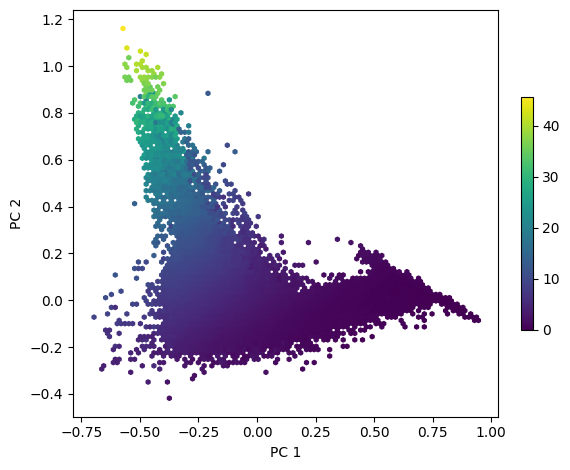

In [10]:
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('feature_space_colored_by_DC.pdf')
plt.show()

[[16925, 16925, 16925], [93408, 16925, 203, 203, 203], [42127, 11682, 20812, 944, 11704, 17455], [24941, 19443, 14330, 944, 3467, 20676, 30919, 30919, 30919], [36114, 34278, 16925, 4045], [96377, 93878], [35574, 21046, 4045, 944, 11545, 17455, 17455], [61270, 19960, 3752, 3752, 3752, 11704, 17455, 17455], [50295, 36200, 20812, 8873, 17455, 17455, 17455, 17455, 30919, 36414, 36414], [46998, 39773, 2490, 944, 11704, 17455, 17455, 17455, 30919, 30919]]
[16925, 93408, 42127, 24941, 36114, 96377, 35574, 61270, 50295, 46998]
[16925, 16925, 11682, 19443, 34278, 93878, 21046, 19960, 36200, 39773]
[16925, 203, 20812, 14330, 16925, 4045, 3752, 20812, 2490]
[203, 944, 944, 4045, 944, 3752, 8873, 944]
[203, 11704, 3467, 11545, 3752, 17455, 11704]
[17455, 20676, 17455, 11704, 17455, 17455]
[30919, 17455, 17455, 17455, 17455]
[30919, 17455, 17455, 17455]
[30919, 30919, 30919]
[36414, 30919]
[36414]


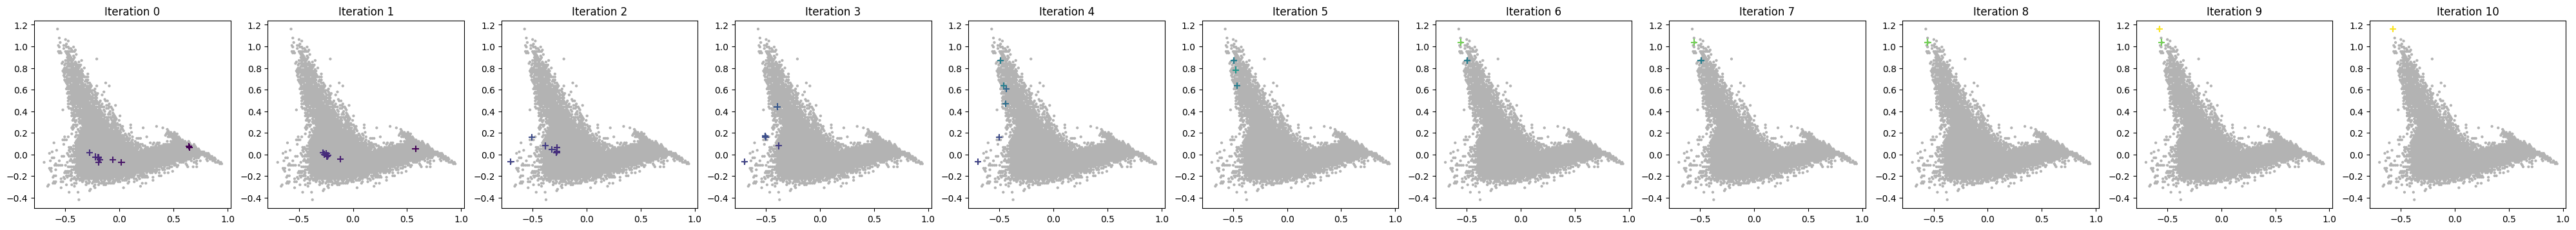

In [13]:
# Generaing a figure to show how the particles in EPSO move around
fig, ax = plt.subplots(1, (num_iterations + 1), figsize=(40, 40))
fig.tight_layout()
print(all_positions)


for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(nb_COFs), cmap="binary", vmin=0, vmax=1)

for i in range( (num_iterations + 1) ):

    ids_acquired = []
    for id in all_positions:
        if i < len(id):
            ids_acquired.append(id[i])

    print(ids_acquired)
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('Iteration {}'.format(i))

plt.savefig("iterations_!.pdf", bbox_inches="tight")
plt.show()


23


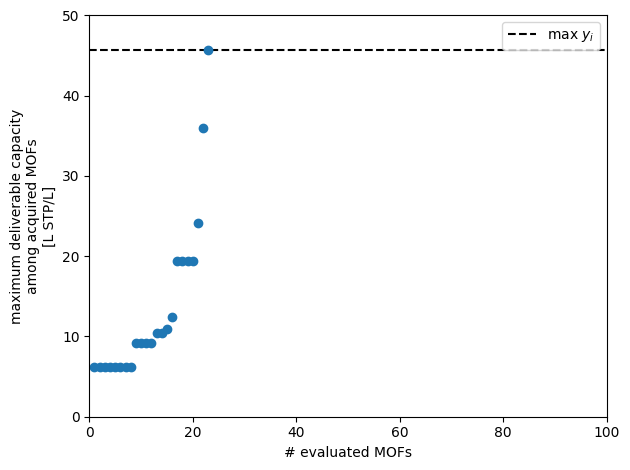

In [14]:
# A scatter plot for a simple EPSO run
x_values = np.arange(1, len(global_max_per_function_call) + 1)

print(len(global_max_per_function_call))

plt.figure()
plt.scatter(x_values, global_max_per_function_call)
plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=45.71, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 50])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [15]:
# Running EPSO many times to generate averages

num_particles = 10
num_dimensions = 7
lower_bound = 0
upper_bound = 1.0
w = 2.0
c1 = 1.0
c2 = 1.0
num_iterations = 10

nb_runs = 50  # Number of runs of this we're doing!

gmpfc_arr = []
apt_arr = []

for run_no in range(nb_runs):
    print("Run No.: ", run_no)
    initial_positions_PSO = random.choices(X, k=num_particles)
    print("Initial Position for Run No. ", run_no, ": ", initial_positions_PSO)
    pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, initial_positions_PSO)
    best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()
    print("best_fitness for Run No. ", run_no, ": ", best_fitness)
    gmpfc_arr.append(global_max_per_function_call)
    apt_arr.append(all_function_calls)

print(gmpfc_arr)
print(apt_arr)

Run No.:  0
Initial Position for Run No.  0 :  [array([0.21553398, 0.08502256, 0.23668467, 0.51515152, 0.01259446,
       0.09998596, 0.09314685]), array([0.13398058, 0.26813128, 0.4737373 , 0.67676768, 0.02602855,
       0.11838225, 0.07398601]), array([0.11456311, 0.30348308, 0.46240069, 0.76767677, 0.03414498,
       0.17932875, 0.12461538]), array([0.08349515, 0.50924923, 0.57605469, 0.83838384, 0.04981808,
       0.15728128, 0.11370629]), array([0.10873786, 0.46496308, 0.67059739, 0.7979798 , 0.03722362,
       0.12301643, 0.1048951 ]), array([0.16699029, 0.21683487, 0.46897888, 0.72727273, 0.02267003,
       0.18045218, 0.09370629]), array([0.07961165, 0.43649128, 0.46523922, 0.82828283, 0.05289673,
       0.24308384, 0.20615385]), array([0.11262136, 0.38562769, 0.57684818, 0.77777778, 0.03526448,
       0.11374807, 0.09944056]), array([0.06990291, 0.63509333, 0.61007454, 0.81818182, 0.05765463,
       0.1460469 , 0.12335664]), array([0.30485437, 0.01638667, 0.063852  , 0.5959596

In [17]:
# Dumping this data into a .pkl file
with open('epso_graph_results.pkl', 'wb') as file:
  pickle.dump({'gmpfc_arr': gmpfc_arr, 'apt_arr': apt_arr}, file)

In [18]:
# Extracting the run with maximum number of unique function calls:
num_iterations_per_run = []
for i in range(len(gmpfc_arr)):
    num_iterations_per_run.append(len(gmpfc_arr[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[34, 26, 27, 18, 34, 15, 29, 38, 29, 33, 28, 26, 21, 17, 24, 16, 35, 32, 22, 30, 33, 23, 35, 32, 32, 34, 29, 32, 28, 32, 21, 21, 33, 29, 18, 32, 33, 28, 18, 31, 24, 28, 37, 20, 31, 36, 19, 34, 20, 28]
38


In [20]:
# Calculating these values! (See Visualizations.ipynb for more info)
y_max_mu = []
y_max_sig_bot = []
y_max_sig_top = []

for i in range(max_num_iterations):
    y_maxes = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes.append(gmpfc_arr[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes)
    y_max_mu.append( np.mean(y_maxes) )
    print("y_max_mu[i]: ", y_max_mu[i])
    print("y_maxes < y_max_mu[i]: ", y_maxes < y_max_mu[i])

    y_maxes_L_y_max_mu_i = y_maxes < y_max_mu[i]
    y_max_sig_bot_temp = []
    for k in range(len(y_maxes_L_y_max_mu_i)):
        if (y_maxes_L_y_max_mu_i[k] == True):
            y_max_sig_bot_temp.append(y_maxes[k])
    y_max_sig_bot.append( np.std ( y_max_sig_bot_temp )  )
    print(y_max_sig_bot[i])

    y_maxes_G_y_max_mu_i = y_maxes > y_max_mu[i]
    y_max_sig_top_temp = []
    for k in range(len(y_maxes_G_y_max_mu_i)):
        if (y_maxes_G_y_max_mu_i[k] == True):
            y_max_sig_top_temp.append(y_maxes[k])
    y_max_sig_top.append( np.std ( y_max_sig_top_temp )  )
    print(y_max_sig_top[i])

print("y_max_mu: ", y_max_mu)
print("y_max_sig_bot: ", y_max_sig_bot)
print("y_max_sig_top: ", y_max_sig_top)


y_maxes for iteration  0 :  [1.83, 3.01, 6.22, 4.76, 5.7, 30.2, 13.59, 7.2, 5.13, 7.219999999999998, 6.52, 7.08, 14.76, 6.63, 4.14, 6.26, 4.89, 6.2, 6.53, 11.26, 5.35, 11.68, 7.55, 1.28, 7.519999999999999, 6.59, 5.16, 3.21, 3.44, 4.54, 21.17, 5.1, 5.07, 9.26, 3.51, 10.92, 5.48, 7.83, 14.74, 8.06, 12.54, 10.37, 0.22, 5.55, 5.18, 2.78, 16.91, 1.59, 1.55, 7.88]
y_max_mu[i]:  7.4232000000000005
y_maxes < y_max_mu[i]:  [ True  True  True  True  True False False  True  True  True  True  True
 False  True  True  True  True  True  True False  True False False  True
 False  True  True  True  True  True False  True  True False  True False
  True False False False False False  True  True  True  True False  True
  True False]
1.8638248241738309
5.689566302090376
y_maxes for iteration  1 :  [4.21, 4.94, 6.22, 4.76, 7.3, 30.2, 13.59, 7.25, 5.5, 8.34, 6.52, 7.08, 14.76, 8.99, 4.18, 23.65, 5.92, 6.2, 7.18, 11.26, 5.6, 11.79, 7.55, 4.85, 7.519999999999999, 6.59, 10.64, 6.58, 5.2, 8.009999999999998, 21.

In [21]:
np_y_max_mu = np.array(y_max_mu)
np_y_max_sig_bot = np.array(y_max_sig_bot)
np_y_max_sig_top = np.array(y_max_sig_top)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


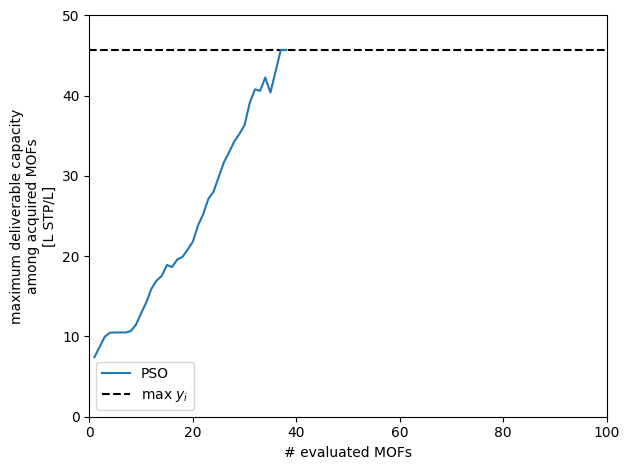

In [22]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu, label="PSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu - np_y_max_sig_bot, np_y_max_mu + np_y_max_sig_top, alpha=0.2, ec="None")

plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=45.71, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 50])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [23]:
with open('epso_graph_outputs.pkl', 'wb') as file:
    pickle.dump({'y_max_mu_epso': y_max_mu, 'y_max_sig_bot_epso': y_max_sig_bot, 'y_max_sig_top_epso': y_max_sig_top}, file)

In [24]:
ids_to_rank = np.argsort(y.squeeze())
print(ids_to_rank)

[98693 98134 98133 ... 35496 35235 36414]


In [25]:
top_100_COF_ids = np.flip(np.argsort(y))[:100]
assert np.size(top_100_COF_ids) == 100
print("top 100 COFs range from y =", np.min(y[top_100_COF_ids]), "to", np.max(y[top_100_COF_ids]))

top 100 COFs range from y = 31.1 to 45.71


In [ ]:
def fraction_in_top100_cofs(ids_acquired):
    nb_in_top_100 = 0
    for id_acquired in ids_acquired:
        if id_acquired in top_100_COF_ids:
            nb_in_top_100 += 1
    return nb_in_top_100 / 100

In [ ]:
# get fraction of aquired MOFs in top 100 for EPSO
def y_top_100(arr):
    y_top100_mu      = np.zeros(max_num_iterations)

    for i in range(max_num_iterations):
        y_ranks = []

        for j in range(nb_runs):
            temp = []
            if ( i < len(arr[j]) ): #only if arr[] has ith function call!
                for k in range(i):
                    temp.append(arr[j][k])
            else:
                temp = arr[j]

            y_ranks.append(temp)

        y_frac_top_100_per_run = []
        for l in y_ranks:
            y_frac_top_100_per_run.append(fraction_in_top100_cofs(l))


        np_y_frac_top_100_per_run = np.array(y_frac_top_100_per_run)

        y_top100_mu[i] = np.mean(np_y_frac_top_100_per_run)


    return y_top100_mu


y_top100_mu_epso = y_top_100(apt_arr)
print(y_top100_mu_epso)


[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0004 0.0008 0.0012 0.0018 0.0022 0.0024 0.0024 0.0032 0.0044 0.0058
 0.0072 0.0076 0.0098 0.013  0.0162 0.0188 0.0218 0.0246 0.0272]


In [26]:
# We're going to "fix" the non-monotonicity of the PSO graph now, by adding dummy samples
gmpfc_arr_fixed = (pickle.load ( open ( 'epso_graph_results.pkl', 'rb' ) ) [ 'gmpfc_arr' ] )
apt_arr_fixed = (pickle.load(open('epso_graph_results.pkl', 'rb'))['apt_arr'])

In [ ]:
print(len(gmpfc_arr_fixed))

50


In [27]:
num_iterations_per_run = []
for i in range(50):
    num_iterations_per_run.append(len(gmpfc_arr_fixed[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[34, 26, 27, 18, 34, 15, 29, 38, 29, 33, 28, 26, 21, 17, 24, 16, 35, 32, 22, 30, 33, 23, 35, 32, 32, 34, 29, 32, 28, 32, 21, 21, 33, 29, 18, 32, 33, 28, 18, 31, 24, 28, 37, 20, 31, 36, 19, 34, 20, 28]
38


In [29]:
for i in range(39):
    if (len(gmpfc_arr_fixed[i]) < max_num_iterations):
        for j in range(max_num_iterations - len(gmpfc_arr_fixed[i])):
            gmpfc_arr_fixed[i].append(45.71)

In [30]:
# Generating the arrays we will use to plot our final figures:

y_max_mu_fixed = []
y_max_sig_bot_fixed = []
y_max_sig_top_fixed = []

for i in range(max_num_iterations):
    y_maxes_fixed = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr_fixed[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes_fixed.append(gmpfc_arr_fixed[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes_fixed)
    y_max_mu_fixed.append( np.mean(y_maxes_fixed) )
    print("y_max_mu_fixed[i]: ", y_max_mu_fixed[i])
    print("y_maxes_fixed < y_max_mu_fixed[i]: ", y_maxes_fixed < y_max_mu_fixed[i])

    y_maxes_L_y_max_mu_i_fixed = y_maxes_fixed < y_max_mu_fixed[i]
    y_max_sig_bot_temp_fixed = []
    for k in range(len(y_maxes_L_y_max_mu_i_fixed)):
        if (y_maxes_L_y_max_mu_i_fixed[k] == True):
            y_max_sig_bot_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_bot_fixed.append( np.std ( y_max_sig_bot_temp_fixed )  )
    print(y_max_sig_bot_fixed[i])

    y_maxes_G_y_max_mu_i_fixed = y_maxes_fixed > y_max_mu_fixed[i]
    y_max_sig_top_temp_fixed = []
    for k in range(len(y_maxes_G_y_max_mu_i_fixed)):
        if (y_maxes_G_y_max_mu_i_fixed[k] == True):
            y_max_sig_top_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_top_fixed.append( np.std ( y_max_sig_top_temp_fixed )  )
    print(y_max_sig_top_fixed[i])

print("y_max_mu_fixed: ", y_max_mu_fixed)
print("y_max_sig_bot_fixed: ", y_max_sig_bot_fixed)
print("y_max_sig_top_fixed: ", y_max_sig_top_fixed)


y_maxes for iteration  0 :  [1.83, 3.01, 6.22, 4.76, 5.7, 30.2, 13.59, 7.2, 5.13, 7.219999999999998, 6.52, 7.08, 14.76, 6.63, 4.14, 6.26, 4.89, 6.2, 6.53, 11.26, 5.35, 11.68, 7.55, 1.28, 7.519999999999999, 6.59, 5.16, 3.21, 3.44, 4.54, 21.17, 5.1, 5.07, 9.26, 3.51, 10.92, 5.48, 7.83, 14.74, 8.06, 12.54, 10.37, 0.22, 5.55, 5.18, 2.78, 16.91, 1.59, 1.55, 7.88]
y_max_mu_fixed[i]:  7.4232000000000005
y_maxes_fixed < y_max_mu_fixed[i]:  [ True  True  True  True  True False False  True  True  True  True  True
 False  True  True  True  True  True  True False  True False False  True
 False  True  True  True  True  True False  True  True False  True False
  True False False False False False  True  True  True  True False  True
  True False]
1.8638248241738309
5.689566302090376
y_maxes for iteration  1 :  [4.21, 4.94, 6.22, 4.76, 7.3, 30.2, 13.59, 7.25, 5.5, 8.34, 6.52, 7.08, 14.76, 8.99, 4.18, 23.65, 5.92, 6.2, 7.18, 11.26, 5.6, 11.79, 7.55, 4.85, 7.519999999999999, 6.59, 10.64, 6.58, 5.2, 8.00

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
np_y_max_mu_fixed = np.array(y_max_mu_fixed)
np_y_max_sig_bot_fixed = np.array(y_max_sig_bot_fixed)
np_y_max_sig_top_fixed = np.array(y_max_sig_top_fixed)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


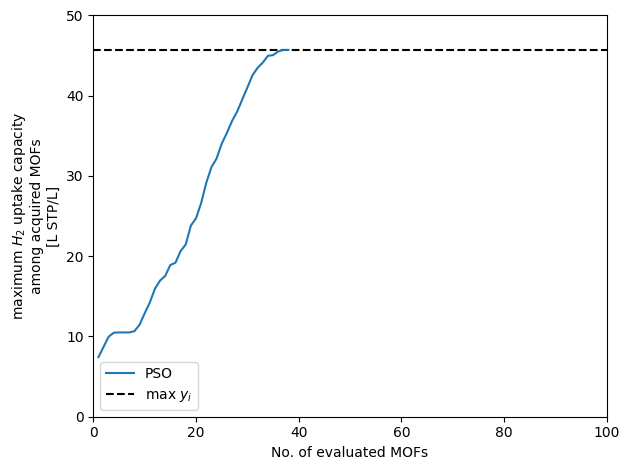

In [34]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu_fixed, label="PSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu_fixed - np_y_max_sig_bot_fixed, np_y_max_mu_fixed + np_y_max_sig_top_fixed, alpha=0.2, ec="None")

plt.xlabel('No. of evaluated MOFs')
plt.ylabel('maximum $H_2$ uptake capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=45.71, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 50])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run_fixed.pdf")
plt.show()

In [33]:
# Dumping fixed output values
with open('epso_graph_outputs_fixed.pkl', 'wb') as file:
    pickle.dump({'y_max_mu_epso_fixed': y_max_mu_fixed, 'y_max_sig_bot_epso_fixed': y_max_sig_bot_fixed, 'y_max_sig_top_epso_fixed': y_max_sig_top_fixed}, file)